In [1]:
import sys
sys.path.append("..")
import MDAnalysis as mda
import nglview as nv
import matplotlib.pyplot as plt
import cellbell
import seaborn as sns
import pickle
import numpy as np
from tqdm import tqdm
sns.set()
RANDOM_SEED = 281090

In [2]:
from MDAnalysis.analysis.dihedrals import Ramachandran, Janin
from spc_analysis import mda_janin_with_CSTV

In [3]:
raw_data_dir = '../data/raw'
interim_data_dir = '../data/interim'
processed_data_dir = '../data/processed'
reports_dir = '../reports'

In [4]:
calculate = False

In [5]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

# Calculate dihedrals

In [6]:
res_list = [50,
 51,
 56,
 58,
 59,
 60,
 61,
 62,
 64,
 75,
 78,
 89,
 93,
 96,
 97,
 98,
 99,
 102,
 103,
 107,
 108,
 109]

In [7]:
nuclei_dic = {
    50: 'Assignment Open CA,C',
    51: 'Assignment Open C',
    56: 'Assignment Open C',
    58: 'Assignment Open CA,C',
    59: 'Assignment Open C,N',
    60: 'Assignment Open CB,N',
    61: 'Assignment Fully-Open CA,CB,N',
    62: 'Assignment Undeter. CB,N',
    64: 'Assignment Undeter. CA,CB',
    75: 'Assignment Open CA',
    78: 'Assignment Open CA,CB',
    89: 'Assignment Undeter. CA',
    93: 'Assignment Undeter. CA',
    96: 'Assignment Open CA,CB,C,N',
    97: 'Assignment Open CB,C,',
    99: 'Assignment Undeter. CA,C,N',
    98: 'Assignment Undeter. CA,CB,N',
    102: 'Assignment Open CA,CB,N',
    103: 'Assignment Open N',
    107: 'Assignment Open CA,CB,N',
    108: 'Assignment Undeter. C,N',
    109: 'Assignment Undeter. CB,C',
}

In [8]:
%%ding
if calculate:
    data = {}
    u_open = mda.Universe(f'{interim_data_dir}/3FB5_lb/protein_sk1_pbc.pdb',
                f'{interim_data_dir}/3FB5_lb/protein_sk1_pbc.xtc')
    u_fully_open = mda.Universe(f'{interim_data_dir}/5VK6_lb/protein_sk1_pbc.pdb',
                f'{interim_data_dir}/5VK6_lb/protein_sk1_pbc.xtc')
    u_closed = mda.Universe(f'{interim_data_dir}/5VKH_lb/protein_sk1_pbc.pdb',
                f'{interim_data_dir}/5VKH_lb/protein_sk1_pbc.xtc')
    for res_name in tqdm(res_list):
        data[res_name] = {}
        for state_name,u in zip(['o', 'fo', 'c'],[u_open, u_fully_open, u_closed]):
            res = u.select_atoms(f'resid {res_name}')
            data[res_name][state_name]= {}
            data[res_name][state_name]['ramachandran'] = Ramachandran(res).run(verbose=False).angles
            data[res_name][state_name]['janin'] = mda_janin_with_CSTV(u,res)
    with open(f'{processed_data_dir}/dihedrals.pkl', 'wb') as handle:
        pickle.dump(data, handle)
else:
    with open(f'{processed_data_dir}/dihedrals.pkl', 'rb') as handle:
        data = pickle.load(handle)

In [9]:
%%ding
if calculate:
    data_xrd = {}
    u_open = mda.Universe(f'{raw_data_dir}/3FB5_lb/charmm_final.pdb')
    u_fully_open2 = mda.Universe(f'{raw_data_dir}/3F7V/charmm_final.pdb')
    u_fully_open = mda.Universe(f'{raw_data_dir}/5VK6_lb/charmm_final.pdb')
    u_closed = mda.Universe(f'{raw_data_dir}/5VKH_lb/charmm_final.pdb')
    for res_name in res_list:
        data_xrd[res_name] = {}
        for state_name,u in zip(['o', 'fo', 'c', 'fo2'],[u_open, u_fully_open, u_closed, u_fully_open2]):
            res = u.select_atoms(f'resid {res_name}')
            data_xrd[res_name][state_name]= {}
            data_xrd[res_name][state_name]['ramachandran'] = Ramachandran(res).run().angles
            data_xrd[res_name][state_name]['janin'] = mda_janin_with_CSTV(u,res)
    with open(f'{processed_data_dir}/dihedrals_XRD.pkl', 'wb') as handle:
        pickle.dump(data_xrd, handle)
else:
    with open(f'{processed_data_dir}/dihedrals_XRD.pkl', 'rb') as handle:
        data_xrd = pickle.load(handle)

## For all amino acids

In [1]:
%%time
sns_blue = sns.color_palette()[0]
sns_orange = sns.color_palette()[1]
sns_green = sns.color_palette()[2]


fig, ax = plt.subplots(len(res_list), 2,sharex=False,sharey=False,figsize=(10,5*len(res_list)))
for i, res_name in tqdm(enumerate(res_list), total=len(res_list)):
    # Ramachandran
    a = data[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='fo',ax=ax[i,0], color=sns_orange)
    a = data_xrd[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='5VK6', marker='*', color='black', markerfacecolor='orange', ls='', ms=8)
    
    a = data[res_name]['o']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='o',ax=ax[i,0], color=sns_blue)
    a = data_xrd[res_name]['o']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='3FB5', marker='o', color='black', markerfacecolor='blue', ls='', ms=8)
    
    a = data[res_name]['c']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='c',ax=ax[i,0], color=sns_green)
    a = data_xrd[res_name]['c']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='5VKH', marker='s', color='black', markerfacecolor='green', ls='', ms=8)
    
    a = data_xrd[res_name]['fo2']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='3FV7', marker='^', color='black', markerfacecolor='red', ls='', ms=8)
    
    ax[i,0].set_xlim([-180,180])
    ax[i,0].set_xlabel(r'$\phi (^{\circ})$', size=15)
    ax[i,0].set_ylabel(r'$\psi (^{\circ})$', size=15)
    ax[i,0].set_ylim([-180,180])
    ax[i,0].set_aspect('equal', 'box')
    
    ax[i,0].set_title(f'{aa_dic[res_name]}{res_name}', fontsize=20)
    # Janin
    a = data[res_name]['fo']['janin']
    if isinstance(a, np.ndarray):
        if a.shape[2] == 2:
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_orange)
            a = data_xrd[res_name]['fo']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='*', color='black', markerfacecolor='orange', ls='', ms=8)
            
            a = data[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_blue)
            a = data_xrd[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='o', color='black', markerfacecolor='blue', ls='', ms=8)
            
            a = data[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_green)
            a = data_xrd[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='s', color='black', markerfacecolor='green', ls='', ms=8)
            
            a = data_xrd[res_name]['fo2']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], label='3FV7', marker='^', color='black', markerfacecolor='red', ls='', ms=8)
            
            
            ax[i,1].set_ylabel(r'$\chi2 (^{\circ})$', size=15)
            ax[i,1].set_ylim([0,360])
            ax[i,1].set_aspect('equal', 'box')
            ax[i,1].legend(loc='best')
        elif a.shape[2] == 1:
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='fo',ax=ax[i,1], color=sns_orange)
            a = data_xrd[res_name]['fo']['janin'].mean()
            ax[i,1].axvline(x=a,c="orange",label='5VK6')
            
            a = data[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='o',ax=ax[i,1], color=sns_blue)
            a = data_xrd[res_name]['o']['janin'].mean()
            ax[i,1].axvline(x=a,c="blue",label='3FB5')
            
            a = data[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='c',ax=ax[i,1], color=sns_green)
            a = data_xrd[res_name]['c']['janin'].mean()
            ax[i,1].axvline(x=a,c="green",label='5VKH')
            
            a = data_xrd[res_name]['fo2']['janin'].mean()
            ax[i,1].axvline(x=a,c="red",label='3FV7')
            
            ax[i,1].set_ylabel(r'$p(\chi1)$', size=15)
            ax[i,1].legend(loc='best')
            
    ax[i,1].set_xlim([0,360])
    ax[i,1].set_xlabel(r'$\chi1 (^{\circ})$', size=15)
    ax[i,1].set_title(f'{aa_dic[res_name]}{res_name}', fontsize=20)
    ax[i,0].legend(loc='best')
    ax[i,0].tick_params(labelsize=13)
    ax[i,1].tick_params(labelsize=13)
    
#fig.delaxes(ax[1,1])
ax[0,0].legend(loc='lower right')
fig.tight_layout()
plt.savefig(f'{reports_dir}/figures/dihedral_analysis.pdf')

NameError: name 'sns' is not defined

## For printing

In [16]:
plt.rcParams["grid.color"] = "#EAEAF2" #
plt.rcParams["axes.facecolor"] = "white"

In [22]:
res_list = [78 , 102 , 103, 107]

100%|██████████| 4/4 [24:06<00:00, 361.61s/it]


CPU times: user 24min 20s, sys: 8.79 s, total: 24min 29s
Wall time: 24min 7s


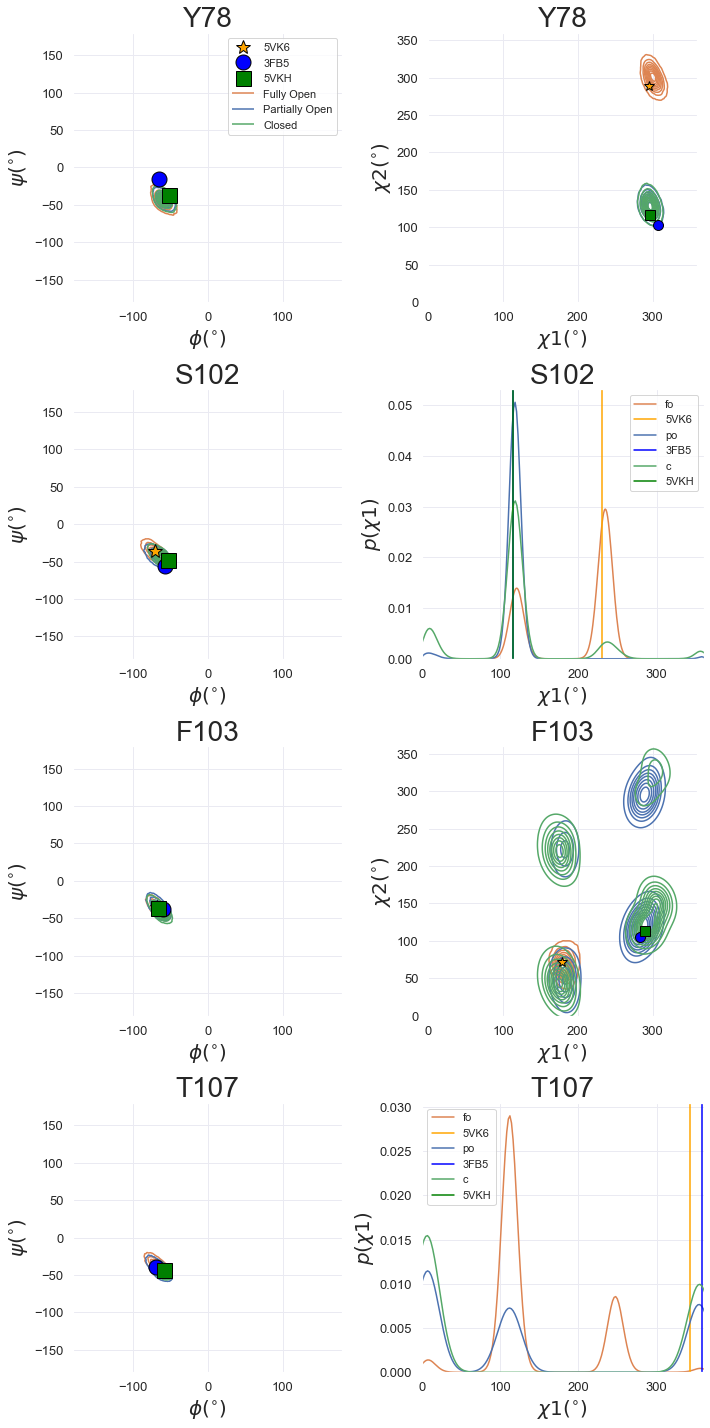

In [24]:
%%time
sns_blue = sns.color_palette()[0]
sns_orange = sns.color_palette()[1]
sns_green = sns.color_palette()[2]


fig, ax = plt.subplots(len(res_list), 2,sharex=False,sharey=False,figsize=(10,5*len(res_list)))
for i, res_name in tqdm(enumerate(res_list), total=len(res_list)):
    # Ramachandran
    a = data[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='Fully Open',ax=ax[i,0], color=sns_orange)
    a = data_xrd[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='5VK6', marker='*', color='black', markerfacecolor='orange', ls='', ms=15)
    
    a = data[res_name]['o']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='Partially Open',ax=ax[i,0], color=sns_blue)
    a = data_xrd[res_name]['o']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='3FB5', marker='o', color='black', markerfacecolor='blue', ls='', ms=15)
    
    a = data[res_name]['c']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='Closed',ax=ax[i,0], color=sns_green)
    a = data_xrd[res_name]['c']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='5VKH', marker='s', color='black', markerfacecolor='green', ls='', ms=15)
    
    
    ax[i,0].set_xlim([-180,180])
    ax[i,0].set_xlabel(r'$\phi (^{\circ})$', size=20)
    ax[i,0].set_ylabel(r'$\psi (^{\circ})$', size=20)
    ax[i,0].set_ylim([-180,180])
    ax[i,0].set_aspect('equal', 'box')
    
    ax[i,0].set_title(f'{aa_dic[res_name]}{res_name}', fontsize=28)
    # Janin
    a = data[res_name]['fo']['janin']
    if isinstance(a, np.ndarray):
        if a.shape[2] == 2:
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_orange)
            a = data_xrd[res_name]['fo']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='*', color='black', markerfacecolor='orange', ls='', ms=10)
            
            a = data[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_blue)
            a = data_xrd[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='o', color='black', markerfacecolor='blue', ls='', ms=10)
            
            a = data[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_green)
            a = data_xrd[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='s', color='black', markerfacecolor='green', ls='', ms=10)
            
            
            ax[i,1].set_ylabel(r'$\chi2 (^{\circ})$', size=20)
            ax[i,1].set_ylim([0,360])
            ax[i,1].set_aspect('equal', 'box')
        elif a.shape[2] == 1:
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='fo',ax=ax[i,1], color=sns_orange)
            a = data_xrd[res_name]['fo']['janin'].mean()
            ax[i,1].axvline(x=a,c="orange",label='5VK6')
            
            a = data[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='po',ax=ax[i,1], color=sns_blue)
            a = data_xrd[res_name]['o']['janin'].mean()
            ax[i,1].axvline(x=a,c="blue",label='3FB5')
            
            a = data[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='c',ax=ax[i,1], color=sns_green)
            a = data_xrd[res_name]['c']['janin'].mean()
            ax[i,1].axvline(x=a,c="green",label='5VKH')
            
            ax[i,1].set_ylabel(r'$p(\chi1)$', size=20)
            ax[i,1].legend(loc='best')
            
    ax[i,1].set_xlim([0,360])
    ax[i,1].set_xlabel(r'$\chi1 (^{\circ})$', size=20)
    ax[i,1].set_title(f'{aa_dic[res_name]}{res_name}', fontsize=28)
    ax[i,0].tick_params(labelsize=13)
    ax[i,1].tick_params(labelsize=13)
    
#fig.delaxes(ax[1,1])
ax[0,0].legend(loc='upper right')
fig.tight_layout()
plt.savefig(f'{reports_dir}/for_print/dihedral_analysis.png')
plt.savefig(f'{reports_dir}/for_print/dihedral_analysis.svg')

In [25]:
res_list = [99, 61]

100%|██████████| 2/2 [07:39<00:00, 229.56s/it]


CPU times: user 7min 43s, sys: 3.5 s, total: 7min 47s
Wall time: 7min 39s


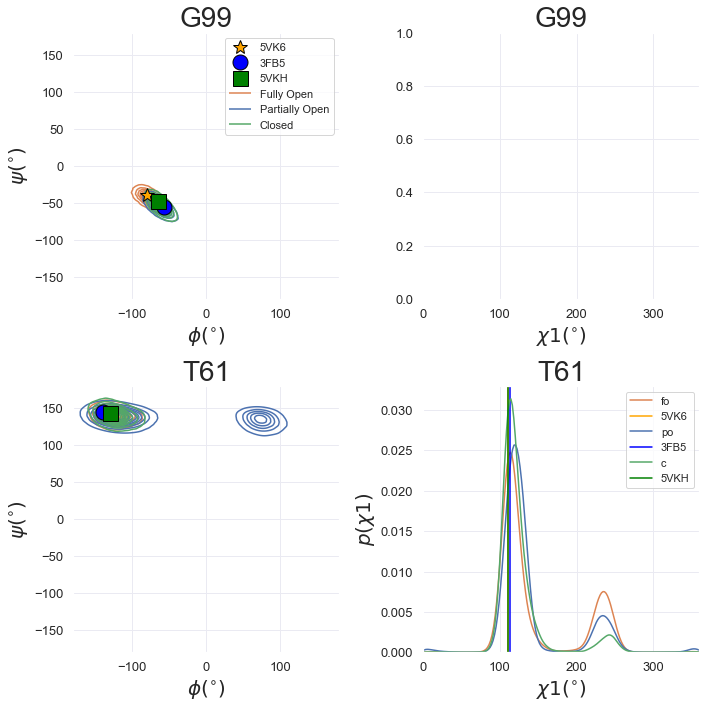

In [26]:
%%time
sns_blue = sns.color_palette()[0]
sns_orange = sns.color_palette()[1]
sns_green = sns.color_palette()[2]


fig, ax = plt.subplots(len(res_list), 2,sharex=False,sharey=False,figsize=(10,5*len(res_list)))
for i, res_name in tqdm(enumerate(res_list), total=len(res_list)):
    # Ramachandran
    a = data[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='Fully Open',ax=ax[i,0], color=sns_orange)
    a = data_xrd[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='5VK6', marker='*', color='black', markerfacecolor='orange', ls='', ms=15)
    
    a = data[res_name]['o']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='Partially Open',ax=ax[i,0], color=sns_blue)
    a = data_xrd[res_name]['o']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='3FB5', marker='o', color='black', markerfacecolor='blue', ls='', ms=15)
    
    a = data[res_name]['c']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:,0],y=a[:,1],label='Closed',ax=ax[i,0], color=sns_green)
    a = data_xrd[res_name]['c']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
    ax[i,0].plot(a[0],a[1], label='5VKH', marker='s', color='black', markerfacecolor='green', ls='', ms=15)
    
    
    ax[i,0].set_xlim([-180,180])
    ax[i,0].set_xlabel(r'$\phi (^{\circ})$', size=20)
    ax[i,0].set_ylabel(r'$\psi (^{\circ})$', size=20)
    ax[i,0].set_ylim([-180,180])
    ax[i,0].set_aspect('equal', 'box')
    
    ax[i,0].set_title(f'{aa_dic[res_name]}{res_name}', fontsize=28)
    # Janin
    a = data[res_name]['fo']['janin']
    if isinstance(a, np.ndarray):
        if a.shape[2] == 2:
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_orange)
            a = data_xrd[res_name]['fo']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='*', color='black', markerfacecolor='orange', ls='', ms=10)
            
            a = data[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_blue)
            a = data_xrd[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='o', color='black', markerfacecolor='blue', ls='', ms=10)
            
            a = data[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2])
            sns.kdeplot(x=a[:,0],y=a[:,1],ax=ax[i,1], color=sns_green)
            a = data_xrd[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1],2]).mean(axis=0)
            ax[i,1].plot(a[0],a[1], marker='s', color='black', markerfacecolor='green', ls='', ms=10)
            
            
            ax[i,1].set_ylabel(r'$\chi2 (^{\circ})$', size=20)
            ax[i,1].set_ylim([0,360])
            ax[i,1].set_aspect('equal', 'box')
        elif a.shape[2] == 1:
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='fo',ax=ax[i,1], color=sns_orange)
            a = data_xrd[res_name]['fo']['janin'].mean()
            ax[i,1].axvline(x=a,c="orange",label='5VK6')
            
            a = data[res_name]['o']['janin']
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='po',ax=ax[i,1], color=sns_blue)
            a = data_xrd[res_name]['o']['janin'].mean()
            ax[i,1].axvline(x=a,c="blue",label='3FB5')
            
            a = data[res_name]['c']['janin']
            a = a.reshape([a.shape[0]*a.shape[1]])
            sns.kdeplot(x=a[:],label='c',ax=ax[i,1], color=sns_green)
            a = data_xrd[res_name]['c']['janin'].mean()
            ax[i,1].axvline(x=a,c="green",label='5VKH')
            
            ax[i,1].set_ylabel(r'$p(\chi1)$', size=20)
            ax[i,1].legend(loc='best')
            
    ax[i,1].set_xlim([0,360])
    ax[i,1].set_xlabel(r'$\chi1 (^{\circ})$', size=20)
    ax[i,1].set_title(f'{aa_dic[res_name]}{res_name}', fontsize=28)
    ax[i,0].tick_params(labelsize=13)
    ax[i,1].tick_params(labelsize=13)
    
#fig.delaxes(ax[1,1])
ax[0,0].legend(loc='upper right')
fig.tight_layout()
plt.savefig(f'{reports_dir}/for_print/dihedral_analysis_SI.png')